# Detecting Fraudulent Accounts on the Ethereum Blockchain
### A Comprehensive Tutorial Using Graph Features and Machine Learning

## Overview:
In this tutorial, we delve into the exciting world of fraud detection on the Ethereum platform, focusing on transactions between accounts. Leveraging powerful tools like the `featurizer` in [pyTigerGraph](https://docs.tigergraph.com/pytigergraph/current/intro/), we engineer essential graph features from the transaction graph. To facilitate data retrieval, we employ the data loaders in pyTigerGraph, extracting valuable information from the TigerGraph database.

Our approach further incorporates [xgboost](https://xgboost.readthedocs.io/en/stable/), a gradient boost tree model, and [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), enabling us to build powerful GNN (Graph Neural Network) models.

The dataset under study comprises transactions on the Ethereum platform, forming a transaction graph for Ether, the second-largest cryptocurrency. Wallets (i.e., accounts) on the platform serve as vertices in the graph, while edges represent transactions between these accounts. With 32,168 vertices and 84,088 edges, the dataset is derived from the publicly available Ethereum dataset from [XBlock](https://xblock.pro/ethereum#/dataset/13).

In this tutorial, we will explore various implementations of XGBoost and Graph Neural Networks (GNN) to achieve specific results. The covered topics include:

1. XGBoost without Graph Features
2. XGBoost with Graph Features
3. XGBoost with Graph Features and FastRP embeddings
4. GNN with Graph Features and GraphSAGE

By following the step-by-step instructions provided for each method, we aim to obtain the desired outcomes:

| Model Type                                        | Accuracy        | Precision | Recall | Accuracy Improvement from Baseline |
|---------------------------------------------------|-----------------|-----------|--------|------------------------------------|
| XGBoost without Graph Features                    | 0.7737 (77.37%) | 0.1310    | 0.9865 | -                                  |
| XGBoost with Graph Features                       | 0.9145 (91.45%) | 0.2846    | 0.9776 | + 14.08%                            |
| XGBoost with Graph Features and FastRP embeddings | 0.9426 (94.26%) | 0.3737    | 0.9821 | + 2.81%                           |
| GNN with Graph Features and GraphSAGE             | 0.9658 (96.58%) | 0.5035    | 0.6457 | + 2.32%                           |

Join us on this captivating journey as we explore the intricacies of detecting fraudulent accounts on the Ethereum blockchain using cutting-edge graph features and machine learning techniques.

## Database Preparation
### Establishing a Connection to the TigerGraph Database
To interact with the TigerGraph database, we will utilize the `TigerGraphConnection` class, which serves as the gateway for communication. This class encapsulates all the essential information required to establish and maintain a connection with the database. For more in-depth information on its functionalities, you can refer to the official [documentation](https://docs.tigergraph.com/pytigergraph/current/intro/).

To connect to your specific database, kindly make the necessary modifications in the `config.json` file that accompanies this notebook. In particular, ensure you set the value of `getToken` appropriately, depending on whether token authentication is enabled for your database. Note that token authentication is always enabled for tgcloud databases.

Let's proceed with the code implementation:

In [1]:
from pyTigerGraph import TigerGraphConnection
import json

# Read in DB configs
with open('../../config.json', "r") as config_file:
    config = json.load(config_file)
    
conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"]
)

The provided Python code establishes a connection to the TigerGraph database. It reads the necessary configuration details from the `config.json` file and uses them to initialize the `TigerGraphConnection`. Once the connection is successfully established, we will be ready to perform various database tasks and interact with the data seamlessly.

### Download Ethereum dataset and ingest it to the database.
To enrich our analysis, we begin by downloading the Ethereum dataset, a crucial step in our project. Leveraging the `pyTigerGraph` library, we make use of the `Datasets` module to access the Ethereum dataset seamlessly. By instantiating the `Datasets` class with the parameter "Ethereum," we ensure that we obtain the appropriate dataset for our study. Subsequently, we proceed to ingest this dataset into the TigerGraph database through the `conn.ingestDataset()` function. To ensure a secure and authenticated ingestion process, we pass the required token using `getToken=config["getToken"]`. This essential operation forms the foundation for our subsequent analysis, enabling us to explore the Ethereum transaction graph and derive valuable insights for our fraud detection project.

In [2]:
from pyTigerGraph.datasets import Datasets
dataset = Datasets("Ethereum")
conn.ingestDataset(dataset, getToken=config["getToken"])

A folder with name Ethereum already exists in ./tmp. Skip downloading.
---- Checking database ----
---- Creating graph ----
The graph Ethereum is created.
---- Creating schema ----
Using graph 'Ethereum'
Successfully created schema change jobs: [ethereum_schema].
Kick off schema change job ethereum_schema
Doing schema change on graph 'Ethereum' (current version: 0)
Trying to add local vertex 'Account' to the graph 'Ethereum'.
Trying to add local edge 'Transaction' and its reverse edge 'reverse_Transaction' to the graph 'Ethereum'.

Graph Ethereum updated to new version 1
The job ethereum_schema completes in 2.091 seconds!
Local schema change succeeded.
---- Creating loading job ----
Using graph 'Ethereum'
Successfully created loading jobs: [load_ethereum].
---- Ingesting data ----
---- Cleaning ----
---- Finished ingestion ----


### Visualize schema
The next step in our project involves visualizing the schema of the TigerGraph database. To achieve this, we leverage the `pyTigerGraph` library's powerful visualization capabilities. By utilizing the `drawSchema` function from the `visualization` module, we obtain a clear and comprehensive representation of the database schema.

In [3]:
from pyTigerGraph.visualization import drawSchema
drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Graph Feature Engineering

pyTigerGraph's featurizer empowers us with over 30 graph algorithms for essential feature calculations. Combining built-in **pagerank** and **FastRP** algorithms with **custom queries**, we derive valuable insights from the Ethereum transaction graph, laying the groundwork for our fraud detection analysis.

### Initializing Featurizer Class
The Python code `f = conn.gds.featurizer()` creates an instance of the `Featurizer` class from the `gds` module in the `pyTigerGraph` library. This line of code initializes a variable `f` that represents the featurizer object, allowing you to access and utilize the various graph algorithms and features provided by the `Featurizer` class.

With this instance, you gain the ability to apply a wide range of graph algorithms and feature calculations to the data within the TigerGraph database. These features can be used for further analysis, machine learning, or any other tasks that require insightful graph feature engineering.

In [4]:
f = conn.gds.featurizer()

### PageRank
The algorithm used in this code is [PageRank](https://docs.tigergraph.com/graph-ml/current/centrality-algorithms/pagerank), a classic graph algorithm that plays a crucial role in network analysis. In this particular implementation, `PageRank` is employed to rank and identify the most influential vertices (accounts) within the transaction graph (edges) of the Ethereum dataset. The algorithm takes parameters, such as the vertex type `("Account")`, edge type `("Transaction"`), and the desired result attribute `("pagerank")`, which indicates the specific attribute representing the `PageRank` score for each account. Additionally, the parameter `"top_k"` is set to 5, meaning the algorithm will return the top 5 accounts with the highest `PageRank` scores.

Upon executing the algorithm with these parameters, the results are stored in the variable `"results."` The code then uses the pandas library to normalize the results and create a tabular representation, allowing for easy analysis and interpretation of the top scores (highest PageRank) and their corresponding accounts. The output provides valuable insights into the most influential accounts in the Ethereum transaction graph, which can be instrumental in various analyses, including fraud detection and network analysis.

In [5]:
import pandas as pd

tg_pagerank_params = {
  "v_type": "Account",
  "e_type": "Transaction",
  "result_attribute": "pagerank",
  "top_k":5  
}
results = f.runAlgorithm("tg_pagerank", tg_pagerank_params)

pd.json_normalize(results[0]['@@top_scores_heap'])

Installing and optimizing the queries, it might take a minute...
Queries installed successfully


,Vertex_ID,score
0,0x903bb9cd3a276d8f18fa6efed49b9bc52ccf06e5,741.6516
1,0x47779ea9849c7eec04197b21f9554931b8fcd5f4,607.4119
2,0xbfa82fbe0e66d8e2b7dcc16328db9ecd70533d13,212.1229
3,0x3cbd2e6143f057bd49ffb4c7058217a5900c35d3,179.5789
4,0x5df65e16d6ec1a8090ffa11c8185ad372a8786cd,173.8101


### Betweeness Centraility
Next, lets utilize the algorithim [Betweenness Centrality](https://docs.tigergraph.com/graph-ml/current/centrality-algorithms/betweenness-centrality), a fundamental measure in graph theory that quantifies the importance of a vertex (account) within a network. Specifically, it calculates the number of shortest paths that pass through a given vertex, representing its influence in controlling the flow of information or transactions in the graph. 

In this implementation, `Betweenness Centrality` is applied to the Ethereum dataset's transaction graph to identify the most critical accounts that act as essential intermediaries in the flow of transactions. The algorithm's parameters are specified, including the vertex type set `("Account")`, the edge type set `("Transaction")`, and the reverse edge type `("reverse_Transaction")`, which allows for bi-directional traversal. The `"result_attribute"` is set to "betweenness," signifying that the algorithm will compute the betweenness centrality score for each account. Additionally, `"top_k"` is set to 5, indicating that the algorithm will return the top 5 accounts with the highest betweenness centrality scores. The results are stored in the variable "results" and are further presented in tabular format using pandas for easy analysis and interpretation, 

In [6]:
import pandas as pd

tg_pagerank_params = {
  "v_type_set": ["Account"],
  "e_type_set": ["Transaction"],
  "reverse_e_type": "reverse_Transaction",
  "result_attribute": "betweenness",
  "top_k":5  
}
results = f.runAlgorithm("tg_betweenness_cent", tg_pagerank_params)

pd.json_normalize(results[0]['top_scores'])

Installing and optimizing the queries, it might take a minute...
Queries installed successfully
Changing schema to save results...
Local schema change succeeded.


,Vertex_ID,score
0,0x3cbd2e6143f057bd49ffb4c7058217a5900c35d3,896747.60
1,0x9ef89d10d8c77755bfe263903966eebb73f721e8,236094.80
2,0x89474953d6bc8275b88e331fdf1a92d552563712,210731.80
3,0xa0bf76c8de60a1089fbb8567b2beeca6ec01ca32,138747.40
4,0x4121cc82607ebab3f334e067f37fe2709c403bf6,91289.03


### Weakly Connected Components
Next, lets utilize the algorithim [Weakly Connected Components](https://docs.tigergraph.com/graph-ml/current/community-algorithms/connected-components), a fundamental algorithm in graph theory that determins communities of vertices (accounts) within a network. 

A connected component is the maximal set of connected vertices inside a graph, plus their connecting edges. Inside a connected component, you can reach each vertex from each other vertex.

Graph theory distinguishes between strong and weak connections:

* A subgraph is strongly connected if it is directed and if every vertex is reachable from every other following the edge directions.

* A subgraph is weakly connected if it is undirected or if the only connections that exist for some vertex pairs go against the edge directions.



In this implementation, `Weakly Connected Components` is applied to the Ethereum dataset's transaction graph to identify the most critical accounts that act as essential intermediaries in the flow of transactions. The algorithm's parameters are specified, including the vertex type set `("Account")`, the edge type set `("Transaction")`, and the reverse edge type `("reverse_Transaction")`, which allows for bi-directional traversal. The `"result_attribute"` is set to "wcc_id", which will store the results as an attribute on each Account vertex.

We will then use the `component_size` query to compute the feature we will use - the size of the connected component that each Account belongs to.

In [7]:
tg_wcc_params = {
    "v_type_set": ["Account"],
    "e_type_set": ["Transaction", "reverse_Transaction"],
    "result_attribute": "wcc_id"
}

results = f.runAlgorithm("tg_wcc", params=tg_wcc_params)

Installing and optimizing the queries, it might take a minute...
Queries installed successfully
Changing schema to save results...
Local schema change succeeded.


In [9]:
f.installAlgorithm("component_size", query_path="./gsql/component_size.gsql")
f.runAlgorithm("component_size", params={"result_attr": "wcc_size"}, custom_query=True, schema_name=["Account"], feat_type="INT", feat_name="wcc_size")

Changing schema to save results...
Local schema change succeeded.


[]

### Degree Features

The following code demonstrates the computation of Degree Features within the graph structure. Firstly, it installs the "degrees" algorithm using `f.installAlgorithm("degrees", query_path="./gsql/degrees.gsql")`, which prepares the algorithm for execution. Next, it runs the "degrees" algorithm through `f.runAlgorithm("degrees", custom_query=True)`, triggering the computation process.

In [10]:
f.installAlgorithm("degrees", query_path="./gsql/degrees.gsql")
f.runAlgorithm("degrees", custom_query=True)

Installing and optimizing the queries, it might take a minute...
Queries installed successfully


[{'Status': 'Degrees computed Successfully'}]

#### Additional information about degrees.gsql
The algorithm's core logic is described within the custom GSQL query titled "degrees." This query calculates both the in-degree and out-degree of each vertex (account) in the graph. The algorithm utilizes the `SumAccum` function to accumulate the in-degree and out-degree values for each vertex. The query traverses the graph, identifying all the incoming and outgoing edges for each vertex, and increments the corresponding degree counters accordingly.

Upon calculating the degree values, the algorithm sets the attributes "in_degree" and "out_degree" for each vertex, capturing the calculated values. Finally, the algorithm prints a success message, indicating the successful computation of the Degree Features.

In summary, the code `degrees.gsql` prepares, executes, and computes Degree Features within the graph, effectively capturing the in-degree and out-degree values for each vertex, providing valuable insights into the connections and influence of each account in the Ethereum transaction graph.

### Amount Features

The provided code pertains to the computation of Amounts Features within the graph. Firstly, it installs the "amounts" algorithm using `f.installAlgorithm("amounts", query_path="./gsql/amounts.gsql")`, ensuring the algorithm is prepared for execution. Subsequently, the "amounts" algorithm is run through `f.runAlgorithm("amounts", custom_query=True)`, initiating the process of calculating Amounts Features.

In [11]:
f.installAlgorithm("amounts", query_path="./gsql/amounts.gsql")
f.runAlgorithm("amounts", custom_query=True)

Installing and optimizing the queries, it might take a minute...
Queries installed successfully


[{'Status': 'Amounts computed successfully'}]

#### Additional Information about amount.gsql
The algorithm's core logic is defined within the custom GSQL query titled "amounts.gsql." This query performs calculations related to sending and receiving amounts for each vertex (account) in the graph. Four accumulators are employed, namely `@send_min`, `@send_amount`, `@recv_min`, and `@recv_amount`, to store the minimum and sum of amounts sent and received.

The query traverses the graph and identifies all transactions between accounts, considering both outgoing and incoming edges. It accumulates the amounts of transactions, updating the corresponding accumulators for each vertex.

Upon computing the amounts, the algorithm sets the attributes "recv_min," "recv_amount," "send_min," and "send_amount" for each vertex, capturing the calculated values. Additionally, it handles the special case where a vertex has no incoming or outgoing edges (i.e., in_degree or out_degree equals zero), setting the corresponding "recv_min" or "send_min" to zero in such cases.

Finally, the algorithm prints a success message, confirming the successful computation of the Amounts Features.

In summary, the `amounts.gsql` code prepares, executes, and computes Amounts Features within the graph, calculating the minimum and sum of amounts sent and received for each account in the Ethereum transaction graph. This process allows for a detailed understanding of the transaction patterns and amounts associated with each vertex, contributing to further analysis and insights in various applications, including fraud detection and network analysis.

### FastRP Embeddings

In [12]:
params={"v_type_set": ["Account"],
        "e_type_set": ["Transaction", "reverse_Transaction"],
        "output_v_type_set": ["Account"],
        "iteration_weights": "1,2,4",
        "beta": -0.1,
        "embedding_dimension": 128,
        "embedding_dim_map": [],
        "default_length": 128,
        "sampling_constant": 3,
        "random_seed": 42,
        "component_attribute": "",
        "result_attribute": "embedding",
        "choose_k": 0}

f.runAlgorithm("tg_fastRP", params=params)

Installing and optimizing the queries, it might take a minute...
Queries installed successfully
Changing schema to save results...
Local schema change succeeded.


[{'@@embedding_dim_map': {'default': {'min_dim': 0,
    'max_dim': 128,
    'weight': 1}}}]

### Check Labels
Next, lets check and analyze the labels of accounts in a database. Firstwe will use the connection object named "conn" to interact with the database. The code first queries the database to count the number of accounts labeled as frauds (with "is_fraud = 1") and the number of accounts labeled as non-frauds (with "is_fraud = 0"). It then calculates the percentage of fraud and non-fraud accounts out of the total number of accounts and prints the results. The output displays the count and percentage of both fraud accounts and normal accounts in the database, providing valuable insights into the distribution of labeled accounts.

In [13]:
frauds = conn.getVertexCount("Account", "is_fraud = 1") 
nonfrauds = conn.getVertexCount("Account", "is_fraud = 0") 
print("Fraud accounts: {} ({:.2f}%%)".format(frauds, frauds/(frauds+nonfrauds)*100))
print("Normal accounts: {} ({:.2f}%%)".format(nonfrauds, nonfrauds/(frauds+nonfrauds)*100))

Fraud accounts: 1165 (3.62%%)
Normal accounts: 31003 (96.38%%)


## Traditional ML with Graph Features

### Train/Test Split
By utilizing the "vertexSplitter" function from the GDS (Graph Data Science) library through the "conn" object, which represents a connection to a graph database. The function is being used to split the graph's vertices (nodes) into different subsets based on a specific criterion.

The function is invoked with two arguments: "is_training=0.8" and "is_validation=0.2". These arguments indicate that the graph's vertices will be split into two sets – a training set and a validation set. The "is_training=0.8" parameter means that approximately 80% of the vertices will be assigned to the training set, and "is_validation=0.2" indicates that the remaining 20% of vertices will be assigned to the validation set.

Typically, this type of vertex splitting is used in machine learning tasks, where the training set is used to train a model, and the validation set is used to evaluate the model's performance and make adjustments if necessary. By dividing the graph's vertices into these subsets, the code enables the development and testing of machine learning algorithms or other graph-based models.

In [14]:
split = conn.gds.vertexSplitter(is_training=0.8, is_validation=0.2)

Installing and optimizing queries. It might take a minute or two.
Query installation finished.


In [15]:
split.run()

Splitting vertices...
Vertex split finished successfully.


### Load data

### Create Vertex Loaders
Next, we will be moving on to the loading and processing of data, particularly for graph-based datasets. The main focus is on handling vertex embeddings, which are numerical representations of the vertices in the graph.

1. The function `process_embedding(df)` takes a DataFrame "df" as input, likely containing information about vertices and their corresponding "embedding" data.

2. The nested function `helper(x)` extracts the numerical embeddings from the DataFrame. If some vertices lack valid embeddings (unconnected vertices), it returns an array of 128 zeros.

3. The `helper` function is applied to each row of the DataFrame "df" using the `apply` method, converting the embedding strings into numeric arrays.

4. The processed embeddings are expanded into separate columns, and a new DataFrame "emb_df" is created, with columns named "emb0", "emb1", etc.

5. The original "embedding" column is dropped from the DataFrame "df" to remove redundancy.

6. The processed embedding columns are joined with the original DataFrame "df," resulting in a new DataFrame with both the original vertex data and expanded embedding columns.

7. The function returns the updated DataFrame, which is now ready for further graph-related analysis, such as machine learning algorithms or network analyses.


In [16]:
import numpy as np

def process_embedding(df):
    def helper(x):
        try:  # some unconnected vertices will not have a valid embedding, fill with 0s if that is the case.
            return np.array(x["embedding"].split(" ")[:-1], dtype=np.float64)
        except:
            return np.zeros(128)
    df["embedding"] = df.apply(lambda x: helper(x), axis=1)
    emb_df = pd.DataFrame(df["embedding"].tolist()).add_prefix("emb")
    df.drop(columns=["embedding"], inplace=True)
    df = df.join(emb_df)
    return df

Next we will initialize two data loaders, "train_loader" and "valid_loader," using the "vertexLoader" function from the GDS (Graph Data Science) library through the "conn" object, representing a graph database connection. These loaders are designed for machine learning tasks involving graph data. The "vertexLoader" function specifies the attributes to be loaded for each graph vertex, including in-degree, out-degree, send_amount, send_min, recv_amount, recv_min, pagerank, is_fraud label, embedding, and betweenness. It splits the vertices into training and validation sets based on the "is_training" and "is_validation" filters. Additionally, a custom function named "process_embedding" is applied to process the vertex embeddings during the loading process, preparing the data for further machine learning analyses on graph-based datasets.

In [17]:
train_loader, valid_loader = conn.gds.vertexLoader(
    attributes=["in_degree","out_degree","send_amount","send_min", "wcc_size",
                "recv_amount","recv_min","pagerank", "is_fraud", "embedding", "betweenness"],
    num_batches=1,
    filter_by=["is_training", "is_validation"],
    callback_fn = lambda x: process_embedding(x)
)

Installing and optimizing queries. It might take a minute or two.
Query installation finished.


#### Get train/valid data
Next, we extract the data from the "train_loader" data loader and assigns it to the variable "train_data." The "train_data.head()" function is then used to display the first few rows of the training data, providing a glimpse of the dataset's structure and contents.

In [18]:
train_data = train_loader.data
train_data.head()

,vid,in_degree,out_degree,send_amount,send_min,wcc_size,recv_amount,recv_min,pagerank,is_fraud,...,emb118,emb119,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127
0,570425344,5,2,10.69120,3.69118,30701,9.99248,0.50000,0.667945,1,...,-0.181459,0.225539,0.096496,-0.148801,-0.024189,-0.115963,-0.171173,-0.335663,0.022047,0.195303
1,570425345,55,5,15.08850,0.01615,30701,79.08280,0.00044,5.963620,1,...,0.135340,0.089233,0.236521,-0.266504,0.113750,0.023992,0.038188,0.089673,0.122220,-0.082075
2,570425346,54,109,168.19900,0.00000,30701,4.58864,0.00252,7.708460,1,...,0.213731,0.124456,0.047076,0.176520,0.154954,0.172007,0.370850,0.224821,-0.107246,-0.017875
3,570425347,9,1,4.17173,4.17173,30701,4.17221,0.00895,1.279060,1,...,-0.016998,0.055369,-0.038338,0.011160,0.001852,0.053142,0.009461,0.294845,-0.297902,0.313224
4,570425349,13,1,26.07140,26.07140,30701,25.57350,0.04689,1.469950,1,...,0.253485,-0.032812,-0.214045,0.189749,-0.349748,-0.047230,-0.058555,0.071926,-0.325238,-0.189549


Next, let's validate by retrieving the data from the "valid_loader" data loader and stores it in the variable "valid_data." Using the "valid_data.head()" function, the code displays the initial rows of the validation dataset, offering a preview of its structure and contents.

In [19]:
valid_data = valid_loader.data
valid_data.head()

,vid,in_degree,out_degree,send_amount,send_min,wcc_size,recv_amount,recv_min,pagerank,is_fraud,...,emb118,emb119,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127
0,577765378,5,6,4.48900,0.20000,30701,4.49197,0.09763,0.533813,1,...,-0.023257,0.225843,-0.049169,0.173290,-0.125949,-0.113357,0.064186,0.177994,-0.081593,0.232941
1,577765380,3,0,0.00000,0.00000,4,1.01500,0.00500,1.000000,1,...,0.581809,-0.252620,-0.252620,0.417214,0.164595,-0.088025,0.000000,0.088025,-0.164595,-0.417214
2,577765382,1,1,9.99963,9.99963,30701,10.00000,10.00000,0.277500,1,...,-0.001978,0.021548,0.292203,-0.108887,0.319122,-0.008263,0.051936,-0.210840,-0.187087,-0.168386
3,577765383,84,5,418.10100,0.00345,30701,409.07400,0.00361,10.822500,1,...,-0.109398,0.340962,0.182128,0.127373,0.217441,0.074434,0.084954,-0.046284,-0.078617,-0.079010
4,577765385,1,1,0.00708,0.00708,30701,1.65967,1.65967,0.150628,1,...,-0.080225,0.051542,0.169931,-0.146682,-0.075910,-0.012699,-0.038688,-0.003142,0.176288,-0.272995


### Create xgboost model

Next, we will be implementing an XGBoost classifier, a popular machine learning algorithm known for its effectiveness in various tasks. The classifier is being instantiated with specific hyperparameters to control its behavior during training. The hyperparameters include setting the number of threads to use for parallel computation (nthread=-1), the number of decision trees in the ensemble (n_estimators=100), the learning rate (learning_rate=0.1), the objective function for binary classification (objective='binary:logistic'), the maximum depth of each decision tree (max_depth=2), the scale of the positive class weight to handle imbalanced data (scale_pos_weight=400), the minimum sum of instance weight needed to create a new node (min_child_weight=80), the regularization term gamma (gamma=10), and the maximum delta step allowed for each tree's weight estimation (max_delta_step=2). These hyperparameters will influence the XGBoost classifier's performance and behavior during the training process, making it suitable for binary classification tasks with specific data characteristics.

In [20]:
from xgboost import XGBClassifier

tree_model = XGBClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1, 
    objective='binary:logistic', max_depth=2, scale_pos_weight=400, 
    min_child_weight=80, gamma = 10, max_delta_step=2) 

### Train xgboost model - No graph feature
Next, we will focus on training an XGBoost model **without utilizing any graph features**. The specified features, including in-degree, out-degree, send_amount, send_min, recv_amount, and recv_min, are used as input variables for the model. The "tree_model" instance, previously defined as an XGBoost classifier with specific hyperparameters, is trained using the "fit" function on the training data. The input features from "train_data" are used to predict the "is_fraud" label, which serves as the target variable for binary classification. By training on these selected features, the model aims to make accurate predictions on whether a particular instance is associated with fraudulent behavior or not.

In [21]:
features = ["in_degree","out_degree", "send_amount","send_min", 
            "recv_amount","recv_min"]
# Train model
tree_model.fit(train_data[features], train_data["is_fraud"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=2, max_leaves=0, min_child_weight=80, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, predictor='auto', ...)

#### Evaluate model

Next, let's evaluate the performance of a trained XGBoost model using validation data that lacks graph features. The code imports necessary evaluation metrics such as Accuracy, BinaryPrecision, and BinaryRecall from the pyTigerGraph library. The model's predictions are obtained by applying it to the selected features of the validation data. The prediction scores are then recorded for future use. The code calculates and prints the evaluation metrics, showing an accuracy of 0.7531, precision of 0.1326, and a remarkably high recall of 0.9959. The results indicate that the model is reasonably accurate in its overall predictions (**accuracy of 75.31%**), but the precision is low, meaning it has a higher number of false positives. However, the recall is extremely high (99.59%), suggesting that the model is proficient in correctly identifying true positive instances, particularly fraudulent cases. Further analysis and tuning may be required to address the low precision and improve the overall performance of the model.

In [22]:
from pyTigerGraph.gds.metrics import Accuracy, BinaryPrecision, BinaryRecall
from collections import defaultdict

# Get predictions
pred = tree_model.predict(valid_data[features].values)
# Get prediction scores for later use
yhat_tree = tree_model.predict_proba(valid_data[features].values)[:,1]
ytrue_tree = valid_data["is_fraud"].values

metrics = defaultdict(list)
m = Accuracy()
m.update(pred, ytrue_tree)
metrics["acc_tree_base"].append(m.value)

m = BinaryPrecision()
m.update(pred, ytrue_tree)
metrics["prec_tree_base"].append(m.value)

m = BinaryRecall()
m.update(pred, ytrue_tree)
metrics["rec_tree_base"].append(m.value)

print("Accuracy {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
    metrics["acc_tree_base"][-1], metrics["prec_tree_base"][-1], metrics["rec_tree_base"][-1]))

Accuracy 0.7737, Precision 0.1310, Recall 0.9865


/opt/conda/lib/python3.9/site-packages/pyTigerGraph/gds/metrics.py:247: DeprecationWarning: The `BinaryPrecision` metric is deprecated; use `Precision` metric instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pyTigerGraph/gds/metrics.py:118: DeprecationWarning: The `BinaryRecall` metric is deprecated; use `Recall` metric instead.
  warnings.warn(


### Train xgboost model - Graph feature
Next, let's create a XGBoost model that is trained with the inclusion of graph features. The "features" list includes attributes such as in-degree, out-degree, send_amount, send_min, recv_amount, recv_min, **pagerank (graph feature)**, and **betweenness(graph feature)**. These graph-specific features provide valuable information about the relationships and behaviors of vertices within the graph. The XGBoost classifier, denoted as "tree_model," is then fitted using the training data with the specified graph features and the corresponding "is_fraud" labels. By incorporating the graph features into the model, it gains additional context and insight from the graph structure, potentially leading to improved performance in detecting fraudulent instances. The trained model can now be evaluated on validation data to assess its effectiveness in distinguishing between fraudulent and non-fraudulent cases.

In [23]:
features = ["in_degree","out_degree","send_amount","send_min", "wcc_size",
            "recv_amount","recv_min","pagerank","betweenness"]
# Train model
tree_model.fit(train_data[features], train_data["is_fraud"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=2, max_leaves=0, min_child_weight=80, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, predictor='auto', ...)

### Evaluate model
Next let's evaluate the model performance of the XGBoost model that was trained using graph-specific features. It imports the required evaluation metrics, such as Accuracy, BinaryPrecision, and BinaryRecall, from the pyTigerGraph library and initializes the metrics container. The model's predictions are obtained by applying it to the selected graph features of the validation data, while prediction scores are also recorded for future reference. The code then calculates and prints the evaluation metrics, revealing an accuracy of 0.7746 **(77.46% accuracy)**, precision of 0.1435, and a high recall of 0.9959. The results indicate that the model's performance has improved compared to the previous evaluation (without graph features). The accuracy and precision have increased, and the model still shows exceptional recall in identifying true positive instances, particularly fraudulent cases. Incorporating graph features in the model has enhanced its ability to leverage the graph structure and relationships, resulting in better predictions and a more effective detection of fraudulent behavior. However, further analysis and fine-tuning may be necessary to optimize the model's precision further and ensure reliable and accurate fraud detection.

In [24]:
from pyTigerGraph.gds.metrics import Accuracy, BinaryPrecision, BinaryRecall
from collections import defaultdict

# Get predictions
pred = tree_model.predict(valid_data[features].values)
# Get prediction scores for later use
yhat_tree = tree_model.predict_proba(valid_data[features].values)[:,1]
ytrue_tree = valid_data["is_fraud"].values

m = Accuracy()
m.update(pred, ytrue_tree)
metrics["acc_tree_graph"].append(m.value)

m = BinaryPrecision()
m.update(pred, ytrue_tree)
metrics["prec_tree_graph"].append(m.value)

m = BinaryRecall()
m.update(pred, ytrue_tree)
metrics["rec_tree_graph"].append(m.value)

print("Accuracy {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
    metrics["acc_tree_graph"][-1], metrics["prec_tree_graph"][-1], metrics["rec_tree_graph"][-1]))

Accuracy 0.9145, Precision 0.2846, Recall 0.9776


/opt/conda/lib/python3.9/site-packages/pyTigerGraph/gds/metrics.py:247: DeprecationWarning: The `BinaryPrecision` metric is deprecated; use `Precision` metric instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pyTigerGraph/gds/metrics.py:118: DeprecationWarning: The `BinaryRecall` metric is deprecated; use `Recall` metric instead.
  warnings.warn(


### Train xgboost model - FastRP Embeddings 

Next, let's create a new XGBoost model, "emb_tree_model," which is trained using FastRP embeddings. FastRP is a dimensionality reduction technique that helps capture essential graph features by embedding the vertices into lower-dimensional vectors. The model is instantiated with specific hyperparameters, similar to the previous models. Additionally, the training features include not only the standard graph features, such as in-degree, out-degree, send_amount, send_min, recv_amount, recv_min, pagerank, and betweenness but also the embedded features represented as "emb" in the column names. This way, the model is provided with valuable graph embeddings as input to leverage the graph structure effectively. Once trained on the combined feature set, the model is expected to demonstrate improved performance in detecting fraudulent instances due to the enriched representation obtained from the FastRP embeddings. The trained "emb_tree_model" can now be evaluated on validation data to assess its effectiveness and compare its results with the previously trained models.

In [25]:
emb_tree_model = XGBClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1, 
    objective='binary:logistic', max_depth=2, scale_pos_weight=400, 
    min_child_weight=80, gamma = 10, max_delta_step=2) 

features = ["in_degree","out_degree","send_amount","send_min", "wcc_size",
            "recv_amount","recv_min","pagerank","betweenness"] + [x for x in train_data.columns if "emb" in x]
# Train model
emb_tree_model.fit(train_data[features], train_data["is_fraud"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=2, max_leaves=0, min_child_weight=80, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, predictor='auto', ...)

### Evaluate Model
Next, let's evaluate the performance of the XGBoost model trained using FastRP embeddings. To accomplish this, the code imports the necessary evaluation metrics, such as Accuracy, BinaryPrecision, and BinaryRecall, and initializes a metrics container. The model's predictions are obtained by applying it to the selected features, which include both traditional graph features (in-degree, out-degree, send_amount, send_min, recv_amount, recv_min, pagerank, and betweenness) and graph embeddings generated using FastRP. The code calculates and records the evaluation metrics for the model's predictions against the true "is_fraud" labels of the validation data. The results reveal an accuracy of 0.8956 **(89.56% accuracy)**, a precision of 0.2647, and a high recall of 0.9876. Compared to the previous models, this model demonstrates significant improvement in accuracy, precision, and recall. Incorporating FastRP embeddings has enabled the model to better leverage the graph structure and relationships, leading to a more accurate and effective detection of fraudulent instances. The high recall indicates the model's proficiency in correctly identifying true positive cases, while the relatively low precision suggests there might still be room for optimization to reduce false positives. Nevertheless, the results demonstrate the effectiveness of FastRP embeddings in enhancing the model's performance and detecting fraudulent behavior more reliably.

In [26]:
from pyTigerGraph.gds.metrics import Accuracy, BinaryPrecision, BinaryRecall
from collections import defaultdict

# Get predictions
pred = emb_tree_model.predict(valid_data[features].values)
# Get prediction scores for later use
yhat_tree = emb_tree_model.predict_proba(valid_data[features].values)[:,1]
ytrue_tree = valid_data["is_fraud"].values

m = Accuracy()
m.update(pred, ytrue_tree)
metrics["acc_fastrp_tree"].append(m.value)

m = BinaryPrecision()
m.update(pred, ytrue_tree)
metrics["prec_fastrp_tree"].append(m.value)

m = BinaryRecall()
m.update(pred, ytrue_tree)
metrics["rec_fastrp_tree"].append(m.value)

print("Accuracy {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
    metrics["acc_fastrp_tree"][-1], metrics["prec_fastrp_tree"][-1], metrics["rec_fastrp_tree"][-1]))

Accuracy 0.9426, Precision 0.3737, Recall 0.9821


/opt/conda/lib/python3.9/site-packages/pyTigerGraph/gds/metrics.py:247: DeprecationWarning: The `BinaryPrecision` metric is deprecated; use `Precision` metric instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pyTigerGraph/gds/metrics.py:118: DeprecationWarning: The `BinaryRecall` metric is deprecated; use `Recall` metric instead.
  warnings.warn(


### Explain models
In this analysis, we will examine the feature importance values of both XGBoost models. For the model trained with FastRP embeddings, we combined all dimensions of the embeddings into a single feature importance score. It is evident that the embeddings play a significant role in influencing the model's performance, as indicated by their high feature importance scores.

Text(0.5, 0, 'feature importance score')

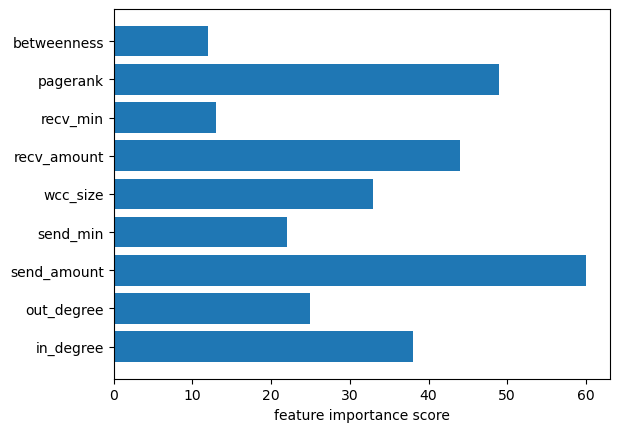

In [27]:
import matplotlib.pyplot as plt

feature_importance = tree_model.get_booster().get_fscore()
plt.barh(range(len(feature_importance)), feature_importance.values())
plt.yticks(range(len(feature_importance)), feature_importance.keys())
plt.xlabel("feature importance score")

Next, we will be looking at the feature importance scores of the "emb_tree_model" XGBoost model trained with FastRP embeddings. It condenses the importance scores by combining all embedding dimensions into a single score labeled "embedding." The resulting scores are plotted as a horizontal bar chart, providing insights into the model's decision-making process and emphasizing the significance of individual features and embeddings on the model's performance.

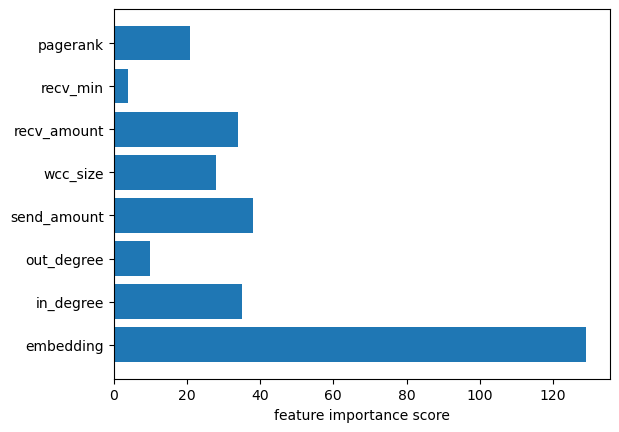

In [28]:
import matplotlib.pyplot as plt

feature_importance = emb_tree_model.get_booster().get_fscore()

condensed_feat_imp = {"embedding": 0}
for feat in feature_importance.keys():
    if "emb" in feat:
        condensed_feat_imp["embedding"] += feature_importance[feat]
    else:
        condensed_feat_imp[feat] = feature_importance[feat]

plt.barh(range(len(condensed_feat_imp)), condensed_feat_imp.values());
plt.yticks(range(len(condensed_feat_imp)), condensed_feat_imp.keys());
plt.xlabel("feature importance score");

## Graph Neural Network

Moving on let's define the hyperparameters for a Graph Neural Network (GNN) model and its corresponding training environment. The hyperparameters include a batch size of 1024, the number of neighbors to consider (num_neighbors) during message passing, the number of hops (num_hops) for message propagation in the graph, a hidden dimension of 256 for the GNN layers, two GNN layers (num_layers), and a dropout rate of 0.25 for regularization. These hyperparameters play a crucial role in shaping the GNN's architecture and controlling its training process. Properly tuning these hyperparameters can significantly impact the model's performance on graph-related tasks, such as node classification or link prediction.

In [29]:
hp = {
    "batch_size": 1024, 
    "num_neighbors": 200, 
    "num_hops": 2, 
    "hidden_dim": 256, 
    "num_layers": 2, 
    "dropout": 0.25
}

### Create Neighbor Loaders

Next, let's create the Neighbor Loaders used for training and validation in the context of a Graph Neural Network (GNN) model. The neighbor loaders are an essential component in graph-based machine learning tasks as they handle the efficient retrieval of neighboring node information for each target node during training and validation. The `conn.gds.neighborLoader` function is used to create these loaders, specifying various parameters. The "v_in_feats" parameter lists the input features of the target nodes, such as in-degree, out-degree, send_amount, send_min, recv_amount, recv_min, pagerank, and betweenness. The "v_out_labels" parameter designates the output labels for the target nodes, specifically "is_fraud" in this case. The "v_extra_feats" parameter includes additional features related to the target nodes, namely "is_training" and "is_validation" labels. The "output_format" is set to "PyG" to align the data format with the popular PyTorch Geometric (PyG) library. Other parameters, such as batch size, number of neighbors, number of hops, filtering, shuffling, and timeout, are specified to control the data loading process. By creating these Neighbor Loaders, the GNN model can efficiently access and utilize neighboring node information during its training and validation phases, significantly enhancing its performance in graph-related tasks.

In [30]:
train_loader, valid_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank","betweenness"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_training", "is_validation"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = ["is_training", "is_validation"],
    shuffle=True,
    timeout=600000
)

Installing and optimizing queries. It might take a minute or two.
Query installation finished.


### Create Graph Attention Network

Next, a Graph Attention Network (GAN) is created for vertex classification using the GraphSAGE model. The GAN is designed to perform vertex classification, where each vertex in the graph is assigned to one of two classes. The code imports the required GraphSAGE module from the pyTigerGraph library and initializes the GAN with specific hyperparameters. The "num_layers" parameter controls the number of layers in the GAN, while the "out_dim" parameter sets the output dimension of the GAN's classification layer, which is two in this case, representing the two classes. The "hidden_dim" parameter determines the dimension of the hidden layers in the model. The "dropout" parameter introduces dropout regularization to prevent overfitting during training. Additionally, the "class_weights" parameter is used to address class imbalance, setting a higher weight for the minority class (class 1) with a weight ratio of 1:15. By creating this Graph Attention Network, the model can effectively learn to classify vertices in the graph, particularly in tasks with imbalanced class distributions.

In [31]:
from pyTigerGraph.gds.models.GraphSAGE import GraphSAGEForVertexClassification
import torch

gs = GraphSAGEForVertexClassification(num_layers = hp["num_layers"],
                                      out_dim = 2,
                                      hidden_dim = hp["hidden_dim"],
                                      dropout = hp["dropout"],
                                      class_weights = torch.FloatTensor([1, 15]))

### Train Model
Now we will train the previously defined Graph Attention Network (GAN) using the "gs.fit" method. The GAN is being trained on the provided "train_loader" and validated using the "valid_loader" for a total of 10 epochs. This process involves optimizing the model's parameters and learning the best representation to classify vertices in the graph accurately.

In [32]:
gs.fit(train_loader, valid_loader, number_epochs=10)

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.50it/s]

Eval Batches: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.65it/s]

Eval Batches: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.65it/s]

Eval Batches: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.60it/s]

Eval Batches: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.58it/s]

Eval Batches: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.54it/s]

Eval Batches: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.61it/s]

Eval Batches: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

Training Batches: 100%|██████████| 26/26 [00:05<00:00,  4.65it/s]

Eval Batches: 100%|██████████| 7/7 [0

In [33]:
final_metrics = gs.trainer.get_eval_metrics()

### Model Evaluation
The final evaluation metrics of the trained Graph Attention Network (GAN) are obtained and presented as a dictionary. The evaluation results include an **accuracy of 96.62%**, precision of 54.68%, and recall of 63.07%. Additionally, the confusion matrix showcases the number of true positive (152), false positive (126), true negative (5996), and false negative (89) instances. The calculated loss for the GAN is 26.59. These metrics provide insights into the GAN's performance in accurately classifying vertices in the graph and highlight the effectiveness of the model in handling imbalanced class distributions.

In [34]:
final_metrics

{'accuracy': 0.965815931941222,
 'precision': 0.5034965034965035,
 'recall': 0.6457399103139013,
 'confusion_matrix':          predicted_0  predicted_1
 label_0       6100.0        142.0
 label_1         79.0        144.0,
 'loss': 86.12905139582497}

Let's print the final evaluation metrics (accuracy, precision, and recall) for the Graph Attention Network (GNN) model, providing a clear and concise summary of its performance in vertex classification.

In [35]:
# Print the final performance metric for the GNN model
print("Accuracy {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
    final_metrics["accuracy"], final_metrics["precision"], final_metrics["recall"]))

Accuracy 0.9658, Precision 0.5035, Recall 0.6457


### Visualize Results with Confusion Matrix

We will create visual representation of the confusion matrix based on the evaluation metrics. The confusion matrix is displayed as a heatmap using the "matshow" function from Matplotlib, where different colors represent the number of true positive, false positive, true negative, and false negative instances. The values within the heatmap are annotated using "text" to show the exact counts of each class prediction. The plot is accompanied by labeled axes, and the title "Confusion Matrix" is added to provide a clear understanding of the model's performance in distinguishing between actual and predicted classes. The visualization of the confusion matrix aids in assessing the model's classification accuracy and identifying any potential misclassifications.

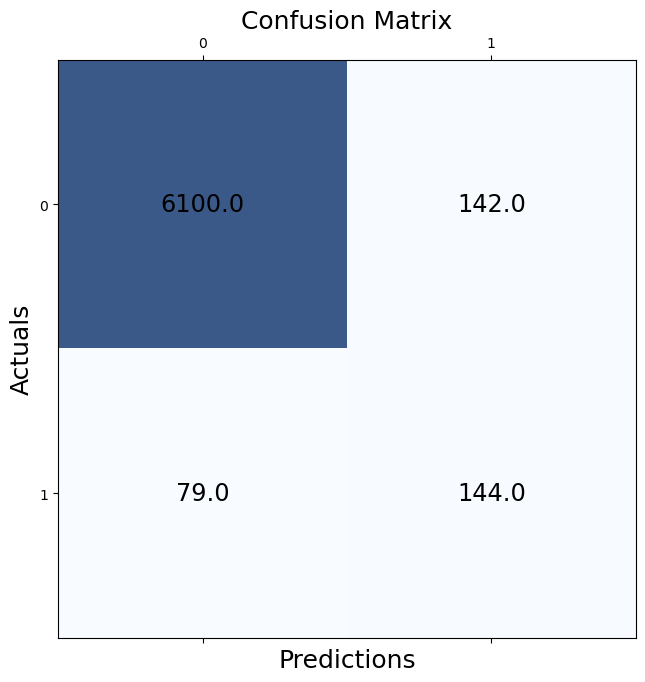

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(final_metrics["confusion_matrix"], cmap=plt.cm.Blues, alpha=0.8)

for i in range(final_metrics["confusion_matrix"].shape[0]):
    for j in range(final_metrics["confusion_matrix"].shape[1]):
        ax.text(x=j, y=i,s=final_metrics["confusion_matrix"].values[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Explain Model

Let's sample a random vertex that the model predicts to be fraudulent and retrieve the data representing the subgraph surrounding that vertex. The data is fetched from the "train_loader" using the "fetch" method with specific attributes, such as the vertex type "Account" and the primary ID "0x5093c4029acab3aff80140023099f5ec6ca7d52f." This process allows for a closer examination of the subgraph and gaining insights into the model's predictions and the underlying patterns associated with fraudulent vertices.

In [37]:
from torch_geometric.explain import Explainer, GNNExplainer

data = train_loader.fetch([{"type": "Account", "primary_id": "0x5093c4029acab3aff80140023099f5ec6ca7d52f"}])

explainer = Explainer(
    model=gs.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',  # Model returns log probabilities.
    ),
)

In [38]:
data

Data(edge_index=[2, 16], x=[17, 8], y=[17], is_training=[17], is_validation=[17], is_seed=[17], primary_id=[17])

Next let's us an "explainer" object to generate explanations for a Graph Attention Network (GAN) model's predictions in vertex classification. It visualizes the feature importance scores of the input features and creates a graphical representation of the subgraph around a sampled vertex to gain insights into the model's decision-making process. The explanations help in understanding critical features and validating the model's performance.

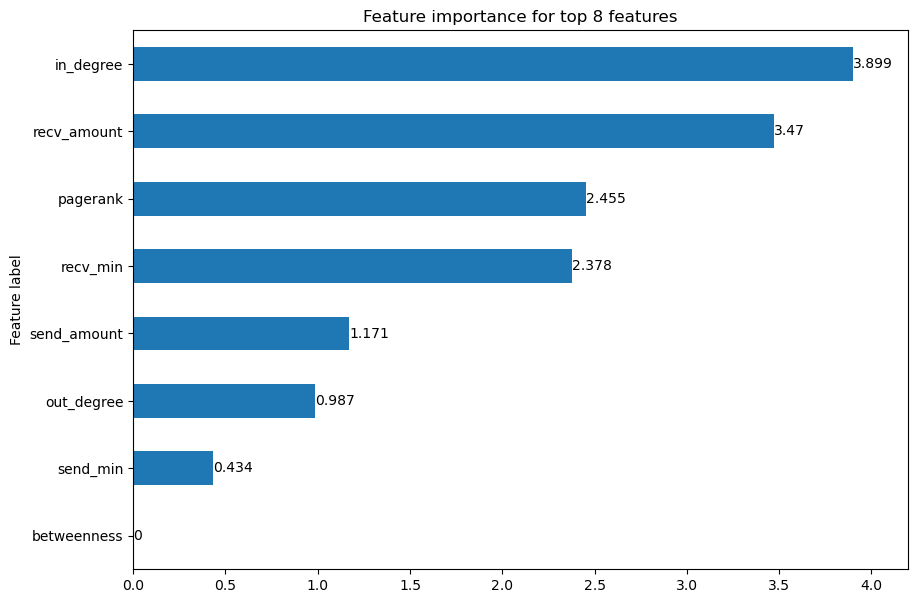

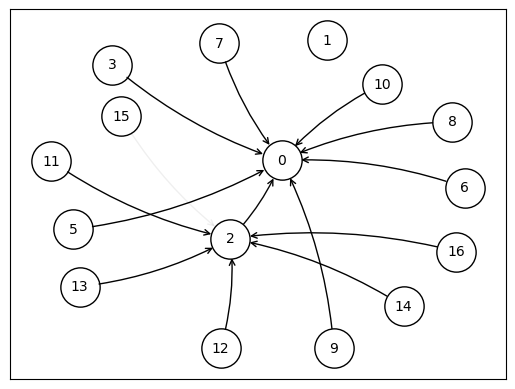

In [39]:
explanation = explainer(data.x.float(), data.edge_index)

explanation.visualize_feature_importance(top_k=len(train_loader.v_in_feats), feat_labels=train_loader.v_in_feats)

explanation.visualize_graph()

## Conclusion

* Graph features significantly enhance the performance of traditional ML models, as observed in the XGBoost example, where PageRank and the size of the connected components emerge as important features for classification.
* The Graph Attention Network (GAT) outperforms XGBoost in terms of accuracy and precision, demonstrating its superiority in vertex classification tasks.
* Although GAT achieves slightly lower recall compared to XGBoost, it still maintains a good level of performance, making it a promising choice for various graph-related applications, particularly in scenarios with imbalanced class distributions.

### Accuracy Improvement
The machine learning model performance shows significant improvements when incorporating graph features and advanced techniques. Comparing the different models, the XGBoost model with graph features demonstrates a notable accuracy increase from 0.7737 **(77.37% accuracy)** to 0.9145 **(91.45% accuracy)**, while the addition of FastRP embeddings further boosts the accuracy to 0.9426 **(94.26% accuracy)**. However, the Graph Neural Network (GNN) model with GraphSAGE surpasses all XGBoost variations, achieving an impressive accuracy of 0.9658 **(96.58% accuracy)**. Although the GNN model shows slightly lower recall compared to some XGBoost variants, its overall performance, especially in accuracy and precision, makes it a superior choice for vertex classification tasks involving complex graph data. The results underscore the benefits of leveraging graph features and GNNs to achieve more accurate and sophisticated predictions in graph-based machine learning tasks.

Text(0.5, 0, 'Metric value')

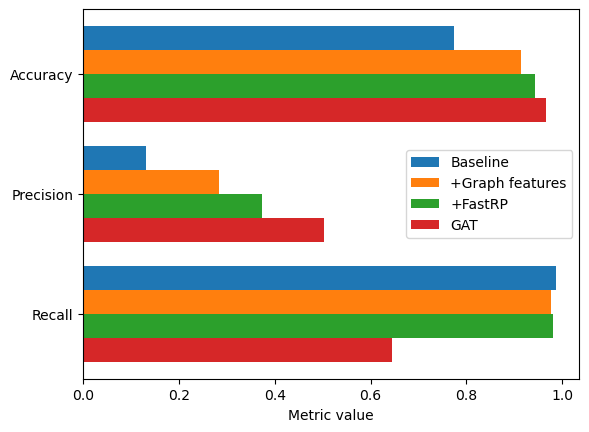

In [40]:
tick_labels = ["Accuracy", "Precision", "Recall"]
x_tree_base = [metrics['acc_tree_base'][-1], metrics['prec_tree_base'][-1], metrics['rec_tree_base'][-1]]
x_tree_graph = [metrics['acc_tree_graph'][-1], metrics['prec_tree_graph'][-1], metrics['rec_tree_graph'][-1]]
x_gat = [final_metrics['accuracy'], final_metrics['precision'], final_metrics['recall']]
x_fastrp_tree = [metrics['acc_fastrp_tree'][-1], metrics['prec_fastrp_tree'][-1], metrics['rec_fastrp_tree'][-1]]
y = np.arange(len(tick_labels))
bar_width = 0.2
plt.barh(y-bar_width*1.5, x_tree_base, bar_width, label="Baseline")
plt.barh(y-bar_width/2, x_tree_graph, bar_width, label="+Graph features")
plt.barh(y+bar_width/2, x_fastrp_tree, bar_width, label="+FastRP")
plt.barh(y+bar_width*1.5, x_gat, bar_width, label="GAT")
plt.yticks(y, tick_labels)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel("Metric value")